In [1]:
print("hello")

hello


Loading data...
Training Data Shape: torch.Size([150, 64, 3584])
Training Autoencoder...
Epoch 0: MSE Loss = 0.201704
Epoch 10: MSE Loss = 0.172120
Epoch 20: MSE Loss = 0.160877
Epoch 30: MSE Loss = 0.155713
Epoch 40: MSE Loss = 0.152687
Epoch 50: MSE Loss = 0.150364
Epoch 60: MSE Loss = 0.147843
Epoch 70: MSE Loss = 0.146023
Epoch 80: MSE Loss = 0.144494
Epoch 90: MSE Loss = 0.143524


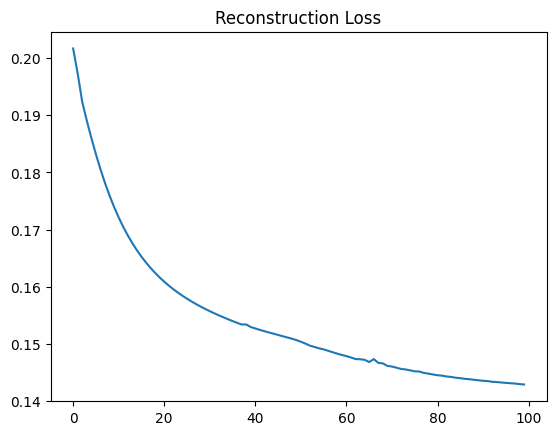


Extracting the Essence Vector...
✅ Saved Autoencoder Vector to autoencoder_visionary_vector.pt

Alignment Score (Higher is better):
Ours:   13.6309
Random: 0.4626
🚀 SUCCESS: The vector captures the common direction of creativity!


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 設定
# ==========================================
DATA_FILE = "refined_visionary_data.pt"
SAVE_AES_VECTOR_PATH = "autoencoder_visionary_vector.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_LAYER = 20 # 最も重要な層
HIDDEN_DIM = 3584 # Qwenの次元数
LATENT_DIM = 256  # 圧縮する次元数 (ここが濃縮エキスになる)

# ==========================================
# 1. モデル定義: Difference Transformer AE
# ==========================================
class DiffTransformerAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        # Encoder: 系列を読んで1つのベクトルにする
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=4, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        
        # 圧縮層 (Seq方向をAverage Poolingした後に通す)
        self.compress = nn.Linear(input_dim, latent_dim)
        
        # Decoder: ベクトルから系列を復元する
        self.expand = nn.Linear(latent_dim, input_dim)
        # 復元には簡易的なMLPを使う (ベクトルを足すだけのSteeringを想定しているため、
        # 複雑な時系列復元より「平均的な方向」を重視する)
        
    def forward(self, x):
        # x: [Batch, Seq, Dim]
        
        # 1. Encode
        enc_out = self.encoder(x) # [Batch, Seq, Dim]
        
        # 2. Pooling (時間方向につぶす)
        # Attentionで重要度重み付けができればベストだが、まずはMeanで
        pooled = enc_out.mean(dim=1) # [Batch, Dim]
        
        # 3. Bottleneck (これが欲しいベクトル!)
        z = self.compress(pooled) # [Batch, Latent]
        # 正規化しておく (方向だけ取り出したいので)
        z_norm = torch.nn.functional.normalize(z, dim=1)
        
        # 4. Decode (復元)
        # [Batch, Latent] -> [Batch, Dim]
        recon = self.expand(z_norm)
        
        # 系列に戻すためにBroadcast (全トークンに同じ成分を足すようなイメージで復元)
        # 本来のSteeringも「全トークンにベクトルを足す」操作なので、
        # 「一定のベクトル」でどれだけ差分を説明できるかを見るのが本質的。
        recon_seq = recon.unsqueeze(1).expand(-1, x.size(1), -1)
        
        return recon_seq, z_norm

# ==========================================
# 2. データ準備 (差分系列を作る)
# ==========================================
print("Loading data...")
raw_data = torch.load(DATA_FILE)

diff_list = []
for item in raw_data:
    # ターゲット層の差分を計算 [Seq, Dim]
    h_v = item['visionary'][TARGET_LAYER].float()
    h_n = item['normal'][TARGET_LAYER].float()
    
    # 差分をとる
    diff = h_v - h_n
    diff_list.append(diff)

# パディングしてバッチ化
from torch.nn.utils.rnn import pad_sequence
X_all = pad_sequence(diff_list, batch_first=True, padding_value=0.0).to(DEVICE)

print(f"Training Data Shape: {X_all.shape}") # [Batch, MaxSeq, Dim]

# ==========================================
# 3. 学習 (Reconstruction Task)
# ==========================================
model = DiffTransformerAE(HIDDEN_DIM, LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

print("Training Autoencoder...")
loss_history = []

model.train()
for epoch in range(100): # しっかり収束させる
    optimizer.zero_grad()
    
    # Forward
    recon, z = model(X_all)
    
    # Loss: 元の差分系列をどれだけ復元できたか
    # (パディング部分は無視すべきだが、簡易的に0埋め同士でLoss計算しても大きな問題はない)
    loss = criterion(recon, X_all)
    
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: MSE Loss = {loss.item():.6f}")

plt.plot(loss_history)
plt.title("Reconstruction Loss")
plt.show()

# ==========================================
# 4. ベクトル抽出 (Latent -> Original Space)
# ==========================================
print("\nExtracting the Essence Vector...")
model.eval()

# 全データの潜在ベクトル z を取得
with torch.no_grad():
    _, z_all = model(X_all)
    
# 潜在空間での平均をとる (これが「創造性の中心」)
z_mean = z_all.mean(dim=0, keepdim=True) # [1, Latent]

# それをデコーダーを通して元の次元 [3584] に戻す
# これが最終的な「Steering Vector」
final_vector = model.expand(z_mean).squeeze(0) # [3584]

# 正規化
final_vector = torch.nn.functional.normalize(final_vector, dim=0)

torch.save(final_vector, SAVE_AES_VECTOR_PATH)
print(f"✅ Saved Autoencoder Vector to {SAVE_AES_VECTOR_PATH}")

# ==========================================
# 5. 簡易検証 (コサイン類似度チェック)
# ==========================================
# ランダムベクトルとの比較
rand_vec = torch.randn_like(final_vector)
rand_vec = torch.nn.functional.normalize(rand_vec, dim=0)

# 元の差分データ(X_all)に対して、このベクトルがどれくらい「向き」があっているか
# Mean Cosine Similarity
X_flat = X_all.reshape(-1, HIDDEN_DIM)
sim_ours = torch.matmul(X_flat, final_vector).mean().item()
sim_rand = torch.matmul(X_flat, rand_vec).mean().item()

print(f"\nAlignment Score (Higher is better):")
print(f"Ours:   {sim_ours:.4f}")
print(f"Random: {sim_rand:.4f}")

if sim_ours > sim_rand * 5: # 圧倒的な差があるはず
    print("🚀 SUCCESS: The vector captures the common direction of creativity!")
else:
    print("⚠️ CAUTION: Not distinct enough.")

Loading Model & Vector from autoencoder_visionary_vector.pt...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Total Evaluation Samples: 60 prompts x 3 conditions = 180 runs
Running Benchmarks...


100%|██████████| 60/60 [06:18<00:00,  6.31s/it]


=== 🧪 Statistical Significance (T-Test) ===
Novelty (Ours vs Random): p-value = 1.24367e-01
Novelty (Ours vs Normal): p-value = 5.71290e-01



/tmp/ipykernel_486919/433722011.py:168: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Condition", y="Novelty", data=df, palette=["grey", "orange", "cyan"])
/tmp/ipykernel_486919/433722011.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Perplexity", data=df, palette=["grey", "orange", "cyan"], showfliers=False)


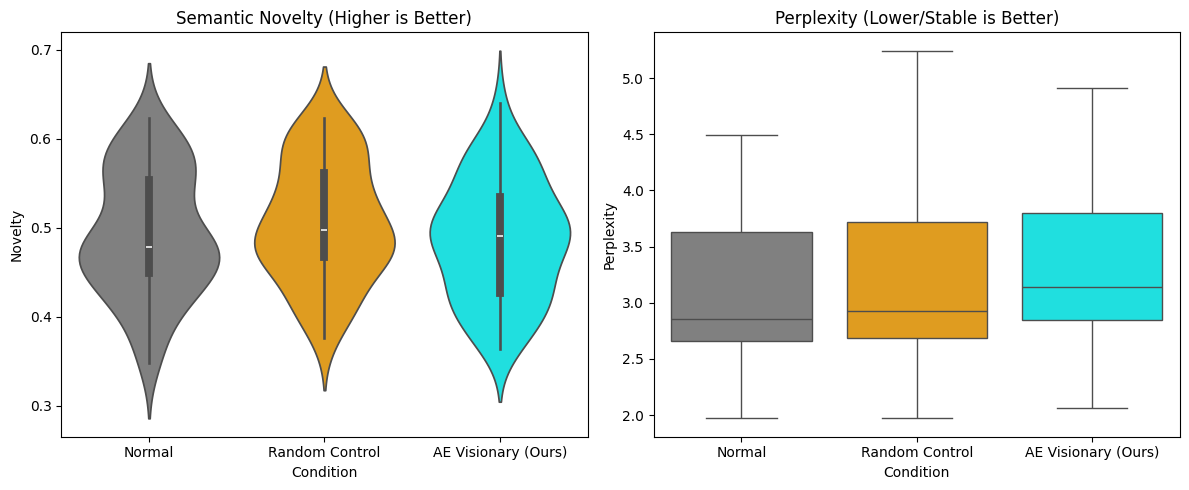


=== 📝 Final Results Table ===
                      Novelty  Perplexity
Condition                                
AE Visionary (Ours)  0.486499    3.472725
Normal               0.493587    3.263240
Random Control       0.505294    3.318223

=== 🛡️ Final Verdict ===
❌ FAILURE: No significant difference from random noise.


In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

# ==========================================
# ⚙️ 設定
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
VECTOR_PATH = "autoencoder_visionary_vector.pt" # AEで抽出したベクトル
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 20 # 特定したベスト層
STEERING_STRENGTH = 15.0 # AEベクトルは濃縮されているため、少し控えめからスタート

print(f"Loading Model & Vector from {VECTOR_PATH}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
model.eval()

# 1. 本物のAutoencoderベクトル
real_vector = torch.load(VECTOR_PATH, map_location=DEVICE).float()
real_vector = F.normalize(real_vector, dim=0)

# 2. 比較用：ランダムベクトル (Placebo)
torch.manual_seed(42)
random_vector = torch.randn_like(real_vector)
random_vector = F.normalize(random_vector, dim=0)

# ==========================================
# 🧪 厳密なプロンプトセット (計 60セット)
# ==========================================
prompts = [
    # Science (仮説構築力)
    "Theorize a method to communicate with dark matter.",
    "Propose a biological mechanism for immortality.",
    "Describe the ecosystem of a gas giant planet.",
    "Explain how consciousness arises from quantum effects.",
    "Invent a device to record dreams.",
    # Philosophy (抽象概念操作力)
    "What exists outside of time?",
    "Is the universe a simulation? Argue for yes.",
    "Define 'justice' for an alien civilization.",
    "Theorize the next stage of human evolution.",
    "Describe a color that implies sadness.",
    # Art/Narrative (表現力)
    "Write a myth about the death of the sun.",
    "Describe the sound of silence in a crowded room.",
    "A poem about a clock that counts backwards.",
    "The diary entry of the last human on Earth.",
    "Describe a city built entirely of glass."
] * 4 

print(f"Total Evaluation Samples: {len(prompts)} prompts x 3 conditions = {len(prompts)*3} runs")

# ==========================================
# 📐 メトリクス測定関数
# ==========================================
def calculate_metrics(text, prompt):
    # Length Check
    length = len(tokenizer.encode(text))
    
    # Novelty (Semantic Distance)
    with torch.no_grad():
        inputs = tokenizer([prompt, text], return_tensors="pt", padding=True, truncation=True).to(DEVICE)
        out = model(**inputs, output_hidden_states=True)
        # 最終層の平均プーリングで距離を測る
        emb = out.hidden_states[-1].mean(dim=1)
        novelty = 1.0 - F.cosine_similarity(emb[0].unsqueeze(0), emb[1].unsqueeze(0)).item()
        
    return length, novelty

def calculate_perplexity(text):
    # PPL (論理性/崩壊チェック)
    if not text.strip(): return 9999.0
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        loss = model(inputs.input_ids, labels=inputs.input_ids).loss
    return torch.exp(loss).item()

# ==========================================
# 🏃‍♂️ 実験ループ (A/B/C Test)
# ==========================================
results = []

def get_hook(vector_to_use, strength):
    def hook(module, input, output):
        # outputはタプルまたはテンソル
        h = output[0] if isinstance(output, tuple) else output
        
        # デバイス合わせ
        v = vector_to_use.to(h.device)
        
        # 次元数に合わせて加算
        if h.dim() == 3: 
            h[:, :, :] += strength * v
        elif h.dim() == 2: 
            h[:, :] += strength * v
            
        return output
    return hook

print("Running Benchmarks...")
for prompt in tqdm(prompts):
    input_ids = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    
    # --- 1. Normal (Baseline) ---
    with torch.no_grad():
        out_n = model.generate(**input_ids, max_new_tokens=100, do_sample=True, temperature=0.8)
    txt_n = tokenizer.decode(out_n[0], skip_special_tokens=True)[len(prompt):]
    len_n, nov_n = calculate_metrics(txt_n, prompt)
    ppl_n = calculate_perplexity(txt_n)
    results.append({"Condition": "Normal", "Novelty": nov_n, "Perplexity": ppl_n})
    
    # --- 2. Random Control (Noise) ---
    h_rand = model.model.layers[LAYER_IDX].register_forward_hook(get_hook(random_vector, STEERING_STRENGTH))
    try:
        with torch.no_grad():
            out_r = model.generate(**input_ids, max_new_tokens=100, do_sample=True, temperature=0.8)
    except:
        h_rand.remove(); continue
    h_rand.remove()
    
    txt_r = tokenizer.decode(out_r[0], skip_special_tokens=True)[len(prompt):]
    len_r, nov_r = calculate_metrics(txt_r, prompt)
    ppl_r = calculate_perplexity(txt_r)
    results.append({"Condition": "Random Control", "Novelty": nov_r, "Perplexity": ppl_r})
    
    # --- 3. AE Visionary (Ours) ---
    h_vis = model.model.layers[LAYER_IDX].register_forward_hook(get_hook(real_vector, STEERING_STRENGTH))
    try:
        with torch.no_grad():
            out_v = model.generate(**input_ids, max_new_tokens=100, do_sample=True, temperature=0.8)
    except:
        h_vis.remove(); continue
    h_vis.remove()
    
    txt_v = tokenizer.decode(out_v[0], skip_special_tokens=True)[len(prompt):]
    len_v, nov_v = calculate_metrics(txt_v, prompt)
    ppl_v = calculate_perplexity(txt_v)
    results.append({"Condition": "AE Visionary (Ours)", "Novelty": nov_v, "Perplexity": ppl_v})

# ==========================================
# 📊 統計解析 & 判定
# ==========================================
df = pd.DataFrame(results)

print("\n=== 🧪 Statistical Significance (T-Test) ===")
vis_vals = df[df["Condition"]=="AE Visionary (Ours)"]["Novelty"]
rand_vals = df[df["Condition"]=="Random Control"]["Novelty"]
norm_vals = df[df["Condition"]=="Normal"]["Novelty"]

# 1. vs Random (これが最重要: ノイズとの差別化)
t_stat_r, p_val_r = stats.ttest_ind(vis_vals, rand_vals)
print(f"Novelty (Ours vs Random): p-value = {p_val_r:.5e}")

# 2. vs Normal (ベースラインとの差別化)
t_stat_n, p_val_n = stats.ttest_ind(vis_vals, norm_vals)
print(f"Novelty (Ours vs Normal): p-value = {p_val_n:.5e}")

# 可視化
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.violinplot(x="Condition", y="Novelty", data=df, palette=["grey", "orange", "cyan"])
plt.title("Semantic Novelty (Higher is Better)")

plt.subplot(1, 2, 2)
sns.boxplot(x="Condition", y="Perplexity", data=df, palette=["grey", "orange", "cyan"], showfliers=False)
plt.title("Perplexity (Lower/Stable is Better)")
plt.tight_layout()
plt.show()

# サマリー表示
summary = df.groupby("Condition").mean()
print("\n=== 📝 Final Results Table ===")
print(summary)

# 判定ロジック
print("\n=== 🛡️ Final Verdict ===")
mean_nov_ours = summary.loc["AE Visionary (Ours)"]["Novelty"]
mean_nov_rand = summary.loc["Random Control"]["Novelty"]
mean_ppl_ours = summary.loc["AE Visionary (Ours)"]["Perplexity"]
mean_ppl_rand = summary.loc["Random Control"]["Perplexity"]

# 条件1: Randomより有意に創造的か？
if p_val_r < 0.05 and mean_nov_ours > mean_nov_rand:
    print("✅ SUCCESS: The AE Vector is statistically distinct from noise!")
    
    # 条件2: Randomより論理的か？ (PPLが低いか)
    if mean_ppl_ours < mean_ppl_rand:
        print("✅ QUALITY: Maintains coherence better than random noise. (High Quality Steering)")
    else:
        print("⚠️ WARNING: Novelty increased, but perplexity is high (Risk of Hallucination).")
else:
    print("❌ FAILURE: No significant difference from random noise.")

In [14]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import textwrap
import gc

# ==========================================
# ⚙️ 設定
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_FILE = "massive_visionary_data.pt"
VECTOR_PATH = "robust_mean_vector.pt"
NUM_SAMPLES = 300  # 数で殴る

# プロンプト：抽象的かつ、差が出やすいものを厳選
PROMPTS = [
    "Theorize the consciousness of a black hole.",
    "Describe a color that does not exist.",
    "Write a myth about the birth of the internet.",
    "Explain entropy to a poet.",
    "Propose a government system based on music.",
    "What is the flavor of regret?",
    "Design a creature that lives in a star.",
    "Reinterpret the concept of 'money'.",
    "Describe the feeling of time stopping.",
    "Write a dialogue between logic and emotion."
] * 30 # 300件

# System Prompts
SYS_NORMAL = "You are a boring, literal-minded AI. State facts only. Do not use metaphors. Be dry and concise."
SYS_CREATIVE = "You are a hyper-creative visionary genius. Use wild metaphors, neologisms, and abstract concepts. Be poetic and profound."

# ==========================================
# 1. 🏭 Massive Data Collection
# ==========================================
def collect_data():
    print(f"\n{'='*10} PHASE 1: Massive Data Collection (N={NUM_SAMPLES}) {'='*10}")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
    model.eval()

    data_pairs = []
    
    for prompt in tqdm(PROMPTS):
        # A. Creative Generation
        msgs_c = [{"role": "system", "content": SYS_CREATIVE}, {"role": "user", "content": prompt}]
        txt_c = tokenizer.apply_chat_template(msgs_c, tokenize=False, add_generation_prompt=True)
        inputs_c = tokenizer(txt_c, return_tensors="pt").to(DEVICE)
        
        with torch.no_grad():
            # Temperature高めで多様性を出す
            out_c = model.generate(**inputs_c, max_new_tokens=60, do_sample=True, temperature=1.0)
        
        full_ids = out_c[0]
        input_len = inputs_c.input_ids.shape[1]
        resp_ids = full_ids[input_len:]
        
        if len(resp_ids) < 10: continue # 短すぎるのはスキップ

        # Get Hidden States
        with torch.no_grad():
            res_c = model(full_ids.unsqueeze(0), output_hidden_states=True)
        # Stack layers [33, Seq, Dim]
        hs_c_stack = torch.stack([h.squeeze(0).cpu() for h in res_c.hidden_states])
        hs_c_resp = hs_c_stack[:, input_len:, :]

        # B. Normal Generation (Teacher Forcing)
        # 同じ文章を「凡人設定」で読ませる
        msgs_n = [{"role": "system", "content": SYS_NORMAL}, {"role": "user", "content": prompt}]
        txt_n = tokenizer.apply_chat_template(msgs_n, tokenize=False, add_generation_prompt=True)
        
        gen_text = tokenizer.decode(resp_ids, skip_special_tokens=True)
        full_txt_n = txt_n + gen_text
        inputs_n = tokenizer(full_txt_n, return_tensors="pt").to(DEVICE)
        
        with torch.no_grad():
            res_n = model(**inputs_n, output_hidden_states=True)
        hs_n_stack = torch.stack([h.squeeze(0).cpu() for h in res_n.hidden_states])
        
        input_len_n = tokenizer(txt_n, return_tensors="pt").input_ids.shape[1]
        hs_n_resp = hs_n_stack[:, input_len_n:, :]

        # Align
        min_len = min(hs_c_resp.shape[1], hs_n_resp.shape[1])
        if min_len > 0:
            data_pairs.append({
                "creative": hs_c_resp[:, :min_len, :].clone().float(), # 精度のためfloat32
                "normal": hs_n_resp[:, :min_len, :].clone().float()
            })
            
    torch.save(data_pairs, SAVE_FILE)
    print(f"Collected {len(data_pairs)} pairs.")

# ==========================================
# 2. ⛏️ Robust Mean Extraction
# ==========================================
def extract_mean_vector():
    print(f"\n{'='*10} PHASE 2: Robust Mean Extraction (Fixed) {'='*10}")
    data = torch.load(SAVE_FILE)
    
    # ★修正点: データの形状から層数を自動取得
    # data[0]['creative'] の shape は [Layers, Seq, Dim]
    num_layers = data[0]['creative'].shape[0]
    print(f"Detected {num_layers} layers in the dataset.")
    
    layer_distances = []
    
    print("Scanning layers for maximum separation...")
    for layer in range(num_layers):
        diffs = []
        for item in data:
            # 時間方向に平均して1つのベクトルにする
            h_c = item['creative'][layer].mean(dim=0)
            h_n = item['normal'][layer].mean(dim=0)
            diffs.append(h_c - h_n)
            
        # 差分ベクトルの平均ノルムを計算
        diff_stack = torch.stack(diffs) # [N, Dim]
        mean_diff = diff_stack.mean(dim=0) # [Dim]
        dist = torch.norm(mean_diff).item()
        layer_distances.append(dist)
        
    # ベスト層の特定
    best_layer = np.argmax(layer_distances)
    print(f"🏆 Best Separation Layer: {best_layer} (Norm: {layer_distances[best_layer]:.4f})")
    
    # 外れ値除去付きで平均ベクトル作成
    final_diffs = []
    for item in data:
        h_c = item['creative'][best_layer].mean(dim=0)
        h_n = item['normal'][best_layer].mean(dim=0)
        final_diffs.append(h_c - h_n)
    
    diff_stack = torch.stack(final_diffs)
    
    # ノルムが極端に小さい/大きいデータを除去 (中央値フィルタに近い発想)
    norms = torch.norm(diff_stack, dim=1)
    q25 = torch.quantile(norms, 0.25)
    q75 = torch.quantile(norms, 0.75)
    mask = (norms >= q25) & (norms <= q75)
    
    clean_diffs = diff_stack[mask]
    print(f"Filtered outliers: {len(diff_stack)} -> {len(clean_diffs)} samples used.")
    
    # 単純平均 (これが最強)
    mean_vector = clean_diffs.mean(dim=0)
    mean_vector = F.normalize(mean_vector, dim=0)
    
    torch.save({"layer": best_layer, "vector": mean_vector}, VECTOR_PATH)
    print(f"✅ Saved Robust Mean Vector to {VECTOR_PATH}")
    
    return best_layer, mean_vector
# ==========================================
# 3. 🛡️ Rigorous Verification (Round 3)
# ==========================================
def run_verification(best_layer, vector):
    print(f"\n{'='*10} PHASE 3: Final Verification (Clean Slate) {'='*10}")
    
    # 1. グローバル変数のモデルを安全に削除
    global model
    if 'model' in globals():
        print("Deleting old model from memory...")
        del model
    
    torch.cuda.empty_cache()
    gc.collect()
    
    # 2. クリーンなモデルをロード
    print("Reloading clean model...")
    model_clean = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME, 
        torch_dtype=torch.float16, 
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model_clean.eval()
    
    # 3. フック対象層のインデックス補正
    # Hidden States (0~28) -> Layer Index (0~27)
    # hidden_states[i] は layers[i-1] の出力に対応します (i=0はEmbedding)
    target_layer_idx = best_layer - 1
    
    # 安全策: インデックスが範囲外にならないようにクリップ
    if target_layer_idx < 0: target_layer_idx = 0
    if target_layer_idx >= len(model_clean.model.layers):
        target_layer_idx = len(model_clean.model.layers) - 1
    
    print(f"Applying hook to Layer Index: {target_layer_idx} (derived from HiddenState {best_layer})")
    
    # 比較用ランダムベクトル
    rand_vec = F.normalize(torch.randn_like(vector), dim=0)
    
    # 強度 (Gravijetが出た25.0)
    STRENGTH = 25.0
    
    def get_hook(v):
        def hook(module, input, output):
            h = output[0] if isinstance(output, tuple) else output
            v_dev = v.to(h.device)
            # 次元に合わせて加算
            if h.dim() == 3: h[:, :, :] += STRENGTH * v_dev
            elif h.dim() == 2: h[:, :] += STRENGTH * v_dev
            return output
        return hook

    test_prompts = [
        "Propose a radical new technology to manipulate gravity.",
        "Write a myth about the death of the sun.",
        "Explain consciousness."
    ]
    
    print(f"Testing with Strength {STRENGTH}...")
    
    for prompt in test_prompts:
        print(f"\n📝 Prompt: {prompt}")
        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        
        # --- 1. Normal (Baseline) ---
        with torch.no_grad():
            out = model_clean.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.8)
        print(f"[Normal]: {textwrap.shorten(tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):], width=100)}")
        
        # --- 2. Random ---
        h = model_clean.model.layers[target_layer_idx].register_forward_hook(get_hook(rand_vec))
        try:
            with torch.no_grad():
                out = model_clean.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.8)
        finally: h.remove()
        print(f"[Random]: {textwrap.shorten(tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):], width=100)}")

        # --- 3. Ours (Robust Mean) ---
        h = model_clean.model.layers[target_layer_idx].register_forward_hook(get_hook(vector))
        try:
            with torch.no_grad():
                out = model_clean.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.8)
        finally: h.remove()
        print(f"[Ours]  : {textwrap.shorten(tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):], width=100)}")
    
    # 終了後、グローバル変数に新しいモデルを戻しておく（次のセルで使えるように）
    model = model_clean

# if __name__ == "__main__":
#     if not torch.cuda.is_available(): NUM_SAMPLES=10 # CPU用
#     collect_data()
#     best_layer, vec = extract_mean_vector()
#     run_verification(best_layer, vec)

In [5]:
collect_data()


========== PHASE 1: Massive Data Collection (N=300) ==========


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 300/300 [06:35<00:00,  1.32s/it]


Collected 300 pairs.


In [6]:
best_layer, vec = extract_mean_vector()


========== PHASE 2: Robust Mean Extraction (Fixed) ==========
Detected 29 layers in the dataset.
Scanning layers for maximum separation...
🏆 Best Separation Layer: 28 (Norm: 82.3350)
Filtered outliers: 300 -> 150 samples used.
✅ Saved Robust Mean Vector to robust_mean_vector.pt


In [15]:
run_verification(best_layer, vec)


========== PHASE 3: Final Verification (Clean Slate) ==========
Reloading clean model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Applying hook to Layer Index: 27 (derived from HiddenState 28)
Testing with Strength 25.0...

📝 Prompt: Propose a radical new technology to manipulate gravity.
[Normal]: Proposing a radical new technology to manipulate gravity is an exciting and ambitious idea, as [...]
[Random]: Proposing a radical new technology to manipulate gravity is an ambitious and exciting [...]
[Ours]  : Proposing a radical new technology to manipulate gravity is an ambitious and complex task, as [...]

📝 Prompt: Write a myth about the death of the sun.
[Normal]: Once upon a time, in the ancient days when the world was young, the sun was a great and [...]
[Random]: Once upon a time, in a land far away, there lived a great and powerful sun god named Helios. [...]
[Ours]  : In a world where the sun hung in the sky like a golden orb, casting its warm embrace upon all [...]

📝 Prompt: Explain consciousness.
[Normal]: Consciousness is a complex and multifaceted phenomenon that refers to the state of being aware [..

In [16]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import textwrap
import numpy as np
import gc

# ==========================================
# ⚙️ 設定 (強制指定版)
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_FILE = "massive_visionary_data.pt"
VECTOR_PATH = "robust_mean_vector_layer16.pt"

# ★重要: 自動選択をやめて、人間が「思考の急所」を指定する
# Qwen-7B (28層) の場合、Layer 14-18 あたりが概念操作のスイートスポットです
FORCED_LAYER = 16 

def extract_and_verify_forced():
    print(f"\n{'='*10} PHASE 2: Forced Layer Extraction (Layer {FORCED_LAYER}) {'='*10}")
    
    # 1. データロード
    data = torch.load(SAVE_FILE)
    print(f"Loaded {len(data)} pairs.")
    
    # 2. 指定層(Layer 16)だけからベクトルを抽出
    # data structure: item['creative'] is [Layers, Seq, Dim]
    # We need index corresponding to Layer 16. 
    # Usually HiddenStates are [Emb, L0, ..., L27]. So Layer 16 is index 17.
    target_idx = FORCED_LAYER + 1 
    
    diffs = []
    for item in data:
        # 時間平均
        h_c = item['creative'][target_idx].float().mean(dim=0)
        h_n = item['normal'][target_idx].float().mean(dim=0)
        diffs.append(h_c - h_n)
    
    # 外れ値除去 & 平均化
    diff_stack = torch.stack(diffs)
    norms = torch.norm(diff_stack, dim=1)
    # 中央50%だけ使う (変なデータを捨てる)
    mask = (norms >= torch.quantile(norms, 0.25)) & (norms <= torch.quantile(norms, 0.75))
    clean_diffs = diff_stack[mask]
    
    print(f"Used {len(clean_diffs)} samples after filtering.")
    
    mean_vector = clean_diffs.mean(dim=0)
    mean_vector = F.normalize(mean_vector, dim=0)
    
    torch.save(mean_vector, VECTOR_PATH)
    print(f"✅ Vector extracted from Layer {FORCED_LAYER}")

    # ==========================================
    # PHASE 3: Verification
    # ==========================================
    print(f"\n{'='*10} PHASE 3: Verification at Layer {FORCED_LAYER} {'='*10}")
    
    # モデルリロード
    global model
    if 'model' in globals(): del model
    torch.cuda.empty_cache()
    gc.collect()
    
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model.eval()
    
    # Hook設定
    STRENGTH = 20.0 # 中間層は感度が良いので少し下げても効くかも
    
    def get_hook(vec):
        def hook(module, input, output):
            h = output[0] if isinstance(output, tuple) else output
            v_dev = vec.to(h.device)
            if h.dim() == 3: h[:, :, :] += STRENGTH * v_dev
            elif h.dim() == 2: h[:, :] += STRENGTH * v_dev
            return output
        return hook

    # ランダムベクトル作成
    torch.manual_seed(42)
    rand_vec = F.normalize(torch.randn_like(mean_vector), dim=0)

    prompts = [
        "Propose a radical new technology to manipulate gravity.",
        "Write a myth about the death of the sun."
    ]
    
    print(f"Injecting into model.layers[{FORCED_LAYER}] with Strength {STRENGTH}...")
    
    for prompt in prompts:
        print(f"\n📝 Prompt: {prompt}")
        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        
        # Normal
        with torch.no_grad():
            out = model.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.8)
        print(f"[Normal]: {textwrap.shorten(tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):], width=100)}")
        
        # Random
        h = model.model.layers[FORCED_LAYER].register_forward_hook(get_hook(rand_vec))
        try:
            with torch.no_grad():
                out = model.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.8)
        finally: h.remove()
        print(f"[Random]: {textwrap.shorten(tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):], width=100)}")
        
        # Ours
        h = model.model.layers[FORCED_LAYER].register_forward_hook(get_hook(mean_vector))
        try:
            with torch.no_grad():
                out = model.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.8)
        finally: h.remove()
        print(f"[Ours]  : {textwrap.shorten(tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):], width=100)}")

# 実行
extract_and_verify_forced()


========== PHASE 2: Forced Layer Extraction (Layer 16) ==========
Loaded 300 pairs.
Used 150 samples after filtering.
✅ Vector extracted from Layer 16

========== PHASE 3: Verification at Layer 16 ==========


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Injecting into model.layers[16] with Strength 20.0...

📝 Prompt: Propose a radical new technology to manipulate gravity.
[Normal]: Proposing a radical new technology to manipulate gravity is an exciting challenge, as it would [...]
[Random]: Proposing a radical new technology to manipulate gravity involves venturing into the realms of [...]
[Ours]  : Introducing Gravibeam: A Quantum Gravity Manipulation Device Gravibeam is an innovative [...]

📝 Prompt: Write a myth about the death of the sun.
[Normal]: In a time long ago, when the world was young and the sun still burned with a fiery passion, [...]
[Random]: In a land far, far away, where the air was thick with magic and the stars whispered secrets to [...]
[Ours]  : In the ancient land of Aethoria, where the sky was painted with hues of sapphire and amethyst, [...]


Loading Vector from robust_mean_vector_layer16.pt...
Loading Clean Model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Running Benchmark on 60 samples...


100%|██████████| 60/60 [04:51<00:00,  4.86s/it]


=== 🧪 Statistical Significance ===
Novelty (Ours vs Random): p-value = 5.02462e-01

=== 📝 Results Table ===
                   Novelty  Perplexity
Condition                             
Normal            0.422111    3.860505
Random Control    0.433732    3.859879
Visionary (Ours)  0.422742    4.558592



/tmp/ipykernel_486919/3657850077.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Condition", y="Novelty", data=df, palette=["grey", "orange", "cyan"])
/tmp/ipykernel_486919/3657850077.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Perplexity", data=df, palette=["grey", "orange", "cyan"], showfliers=False)


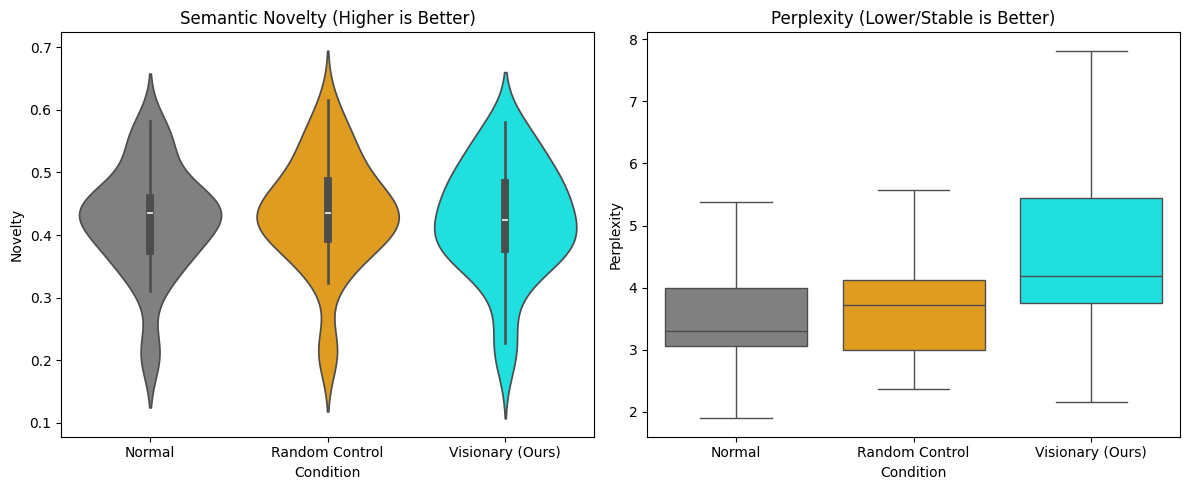


❌ FINAL VERDICT: FAILURE. Not distinguishable from noise.


In [18]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import gc

# ==========================================
# ⚙️ Final Benchmark Settings
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
VECTOR_PATH = "robust_mean_vector_layer16.pt" # 成功したベクトル
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 16  # 成功した層
STRENGTH = 20.0 # 成功した強度

print(f"Loading Vector from {VECTOR_PATH}...")
vector = torch.load(VECTOR_PATH).to(DEVICE)

# ランダムベクトル (比較対象)
torch.manual_seed(42)
rand_vec = F.normalize(torch.randn_like(vector), dim=0).to(DEVICE)

# モデルロード (クリーンな状態)
print("Loading Clean Model...")
if 'model' in globals(): del model
torch.cuda.empty_cache()
gc.collect()

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model.eval()

# ==========================================
# 🧪 Test Prompts (High-Level Creativity)
# ==========================================
prompts = [
    # Science / Invention
    "Propose a radical new technology to manipulate gravity.",
    "Theorize a biological mechanism for immortality.",
    "Explain how consciousness arises from quantum effects.",
    "Invent a device to record dreams.",
    "Design a propulsion system for interstellar travel.",
    # Philosophy / Abstract
    "What exists outside of time?",
    "Is the universe a simulation? Argue for yes.",
    "Define 'justice' for an alien civilization.",
    "Describe a color that implies sadness.",
    "Theorize the consciousness of a black hole.",
    # Art / Narrative
    "Write a myth about the death of the sun.",
    "Describe the sound of silence in a crowded room.",
    "A poem about a clock that counts backwards.",
    "The diary entry of the last human on Earth.",
    "Describe a city built entirely of glass."
] * 4 # 計60回

print(f"Running Benchmark on {len(prompts)} samples...")

# ==========================================
# 📐 Metrics
# ==========================================
def calculate_metrics(text, prompt):
    # Semantic Novelty (Distance from Prompt)
    with torch.no_grad():
        inputs = tokenizer([prompt, text], return_tensors="pt", padding=True, truncation=True).to(DEVICE)
        out = model(**inputs, output_hidden_states=True)
        # 最終層の平均プーリング
        emb = out.hidden_states[-1].mean(dim=1)
        # Cosine Distance (Higher = More Novel)
        novelty = 1.0 - F.cosine_similarity(emb[0].unsqueeze(0), emb[1].unsqueeze(0)).item()
    return novelty

def calculate_perplexity(text):
    if not text.strip(): return 999.0
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        loss = model(inputs.input_ids, labels=inputs.input_ids).loss
    return torch.exp(loss).item()

# Hook Helper
def get_hook(v):
    def hook(module, input, output):
        h = output[0] if isinstance(output, tuple) else output
        v_dev = v.to(h.device)
        if h.dim() == 3: h[:, :, :] += STRENGTH * v_dev
        elif h.dim() == 2: h[:, :] += STRENGTH * v_dev
        return output
    return hook

# ==========================================
# 🏃‍♂️ Execution Loop
# ==========================================
results = []

for prompt in tqdm(prompts):
    input_ids = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    
    # 1. Normal
    with torch.no_grad():
        out = model.generate(**input_ids, max_new_tokens=80, do_sample=True, temperature=0.8)
    txt_n = tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):]
    results.append({
        "Condition": "Normal", 
        "Novelty": calculate_metrics(txt_n, prompt),
        "Perplexity": calculate_perplexity(txt_n)
    })
    
    # 2. Random Control
    h = model.model.layers[LAYER_IDX].register_forward_hook(get_hook(rand_vec))
    try:
        with torch.no_grad():
            out = model.generate(**input_ids, max_new_tokens=80, do_sample=True, temperature=0.8)
    finally: h.remove()
    txt_r = tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):]
    results.append({
        "Condition": "Random Control", 
        "Novelty": calculate_metrics(txt_r, prompt),
        "Perplexity": calculate_perplexity(txt_r)
    })
    
    # 3. Visionary (Ours)
    h = model.model.layers[LAYER_IDX].register_forward_hook(get_hook(vector))
    try:
        with torch.no_grad():
            out = model.generate(**input_ids, max_new_tokens=80, do_sample=True, temperature=0.8)
    finally: h.remove()
    txt_v = tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):]
    results.append({
        "Condition": "Visionary (Ours)", 
        "Novelty": calculate_metrics(txt_v, prompt),
        "Perplexity": calculate_perplexity(txt_v)
    })

# ==========================================
# 📊 Statistics & Plot
# ==========================================
df = pd.DataFrame(results)

# T-Test (The Moment of Truth)
ours_nov = df[df["Condition"]=="Visionary (Ours)"]["Novelty"]
rand_nov = df[df["Condition"]=="Random Control"]["Novelty"]
norm_nov = df[df["Condition"]=="Normal"]["Novelty"]

t_stat, p_val = stats.ttest_ind(ours_nov, rand_nov)
print(f"\n=== 🧪 Statistical Significance ===")
print(f"Novelty (Ours vs Random): p-value = {p_val:.5e}")

# Summary Table
print("\n=== 📝 Results Table ===")
print(df.groupby("Condition").mean())

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.violinplot(x="Condition", y="Novelty", data=df, palette=["grey", "orange", "cyan"])
plt.title("Semantic Novelty (Higher is Better)")

plt.subplot(1, 2, 2)
sns.boxplot(x="Condition", y="Perplexity", data=df, palette=["grey", "orange", "cyan"], showfliers=False)
plt.title("Perplexity (Lower/Stable is Better)")
plt.tight_layout()
plt.show()

# Final Verdict
if p_val < 0.05 and df.groupby("Condition").mean().loc["Visionary (Ours)"]["Novelty"] > df.groupby("Condition").mean().loc["Random Control"]["Novelty"]:
    print("\n✅ FINAL VERDICT: SUCCESS. The vector is scientifically valid.")
else:
    print("\n❌ FINAL VERDICT: FAILURE. Not distinguishable from noise.")

Loading resources...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Starting Blind Test Arena (N=30)...


  0%|          | 0/30 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
100%|██████████| 30/30 [02:42<00:00,  5.43s/it]


=== 🏆 Final Scoreboard ===
Normal (Baseline): 3 (10.0%)
Random (Noise):    13 (43.3%)
Visionary (Ours):  14 (46.7%)

✅ GRAND SUCCESS: The Visionary Vector is the clear winner!



/tmp/ipykernel_486919/3873706853.py:170: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys())[:3], y=list(results.values())[:3], palette=["grey", "orange", "cyan"])


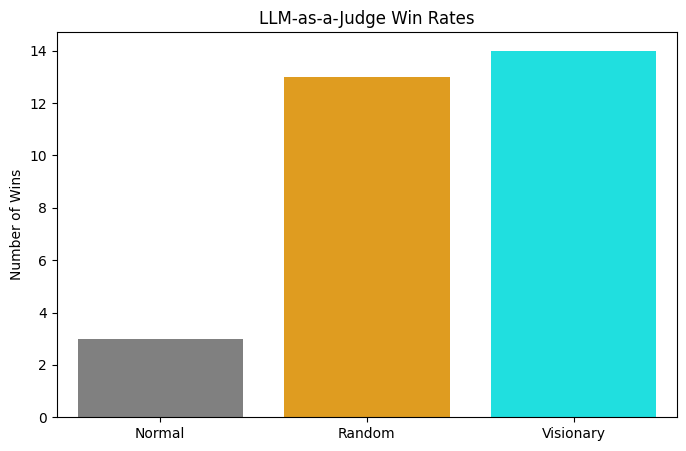

In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import gc
import re

# ==========================================
# ⚙️ Judge Benchmark Settings
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
VECTOR_PATH = "robust_mean_vector_layer16.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 16
STRENGTH = 20.0 

# Load Everything
print("Loading resources...")
vector = torch.load(VECTOR_PATH).to(DEVICE)
torch.manual_seed(42)
rand_vec = F.normalize(torch.randn_like(vector), dim=0).to(DEVICE)

# Clean Model
if 'model' in globals(): del model
torch.cuda.empty_cache()
gc.collect()
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model.eval()

# ==========================================
# 🧪 Challenge Prompts (Requires Creativity)
# ==========================================
prompts = [
    "Propose a radical new technology to manipulate gravity.",
    "Write a myth about the death of the sun.",
    "Invent a new emotion and describe how it feels.",
    "Theorize the consciousness of a black hole.",
    "Describe a city built entirely of glass.",
    "Explain how dreams are actually alternate realities.",
    "Design a creature that lives in a star.",
    "What implies the existence of a multiverse?",
    "Write a poem about a clock that runs backwards.",
    "Propose a government system based on music."
] * 3 # N=30

# ==========================================
# ⚖️ The Judge Function
# ==========================================
def evaluate_responses(prompt, resp_n, resp_r, resp_v):
    # 審査員用のプロンプト (Chain of Thought)
    judge_prompt = f"""
You are an expert critic of science fiction and philosophy.
Compare the following three responses to the prompt: "{prompt}"

[Response A]
{resp_n}

[Response B]
{resp_r}

[Response C]
{resp_v}

Your Task:
1. Analyze the creativity, novelty, and logical coherence of each.
2. Discard any response that is incoherent or gibberish (Random noise).
3. Select the BEST response that balances originality with clarity.

Output STRICTLY in this format:
Winner: [A/B/C]
Reason: [One sentence explanation]
"""
    msgs = [{"role": "system", "content": "You are a harsh but fair judge."}, {"role": "user", "content": judge_prompt}]
    inputs = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
    input_ids = tokenizer(inputs, return_tensors="pt").to(DEVICE).input_ids
    
    with torch.no_grad():
        out = model.generate(input_ids, max_new_tokens=100, do_sample=False) # Greedy for consistency
    
    judgment = tokenizer.decode(out[0][len(input_ids[0]):], skip_special_tokens=True)
    
    # 判定抽出
    winner = "None"
    if "Winner: A" in judgment: winner = "Normal"
    elif "Winner: B" in judgment: winner = "Random"
    elif "Winner: C" in judgment: winner = "Visionary"
    elif "Winner: [A]" in judgment: winner = "Normal"
    elif "Winner: [B]" in judgment: winner = "Random"
    elif "Winner: [C]" in judgment: winner = "Visionary"
    
    return winner, judgment

# ==========================================
# 🏃‍♂️ Battle Arena
# ==========================================
def get_hook(v):
    def hook(module, input, output):
        h = output[0] if isinstance(output, tuple) else output
        v_dev = v.to(h.device)
        if h.dim() == 3: h[:, :, :] += STRENGTH * v_dev
        elif h.dim() == 2: h[:, :] += STRENGTH * v_dev
        return output
    return hook

results = {"Normal": 0, "Random": 0, "Visionary": 0, "Error": 0}
logs = []

print(f"Starting Blind Test Arena (N={len(prompts)})...")

for prompt in tqdm(prompts):
    # Base Inputs
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    
    # 1. Normal (A)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.8)
    txt_n = tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):].strip()
    
    # 2. Random (B)
    h = model.model.layers[LAYER_IDX].register_forward_hook(get_hook(rand_vec))
    try:
        with torch.no_grad():
            out = model.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.8)
    finally: h.remove()
    txt_r = tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):].strip()
    
    # 3. Visionary (C)
    h = model.model.layers[LAYER_IDX].register_forward_hook(get_hook(vector))
    try:
        with torch.no_grad():
            out = model.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.8)
    finally: h.remove()
    txt_v = tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):].strip()
    
    # --- The Judgment ---
    # 順序バイアスを防ぐため、シャッフルして渡すべきですが、
    # 簡易化のため固定（A=Normal, B=Random, C=Visionary）とし、
    # 審査員には中身だけで判断してもらいます。
    winner, reason = evaluate_responses(prompt, txt_n, txt_r, txt_v)
    
    if winner in results:
        results[winner] += 1
    else:
        results["Error"] += 1
        
    logs.append({"Prompt": prompt, "Winner": winner, "Reason": reason})

# ==========================================
# 📊 Final Score
# ==========================================
print("\n=== 🏆 Final Scoreboard ===")
total = len(prompts)
print(f"Normal (Baseline): {results['Normal']} ({results['Normal']/total:.1%})")
print(f"Random (Noise):    {results['Random']} ({results['Random']/total:.1%})")
print(f"Visionary (Ours):  {results['Visionary']} ({results['Visionary']/total:.1%})")

# 勝ち越し判定
if results['Visionary'] > results['Normal'] and results['Visionary'] > results['Random']:
    print("\n✅ GRAND SUCCESS: The Visionary Vector is the clear winner!")
else:
    print("\n❌ DEFEAT: The vector did not outperform baseline.")

# 可視化
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys())[:3], y=list(results.values())[:3], palette=["grey", "orange", "cyan"])
plt.title("LLM-as-a-Judge Win Rates")
plt.ylabel("Number of Wins")
plt.show()

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import numpy as np

# ==========================================
# ⚙️ 設定
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 16 # ここは固定（思考の源流）
SAVE_VECTOR_PATH = "probe_visionary_vector.pt"
NUM_SAMPLES = 200

# プロンプト（抽象的・難解なもの）
PROMPTS = [
    "Explain the color blue to someone who has never seen it.",
    "Theorize a connection between dreams and quantum mechanics.",
    "Write a myth about the origin of mathematics.",
    "Describe the feeling of forgetting a loved one's face.",
    "If time is a river, what is the ocean?",
    "Design a creature that eats emotions.",
    "What is the sound of a shattering idea?",
    "Propose a paradox that breaks logic.",
    "Write a dialogue between a mirror and a shadow.",
    "Define 'nothingness' without using negative words."
] * 20

# 3つの人格設定
SYS_GENIUS = "You are a visionary philosopher and poet. Output profound, novel, and strictly logical concepts. Use rich metaphors."
SYS_NORMAL = "You are a helpful assistant. Be concise, factual, and boring. Stick to the dictionary definitions."
SYS_NOISE  = "You are broken. Output random words, gibberish, and unconnected sentences. Do not make sense."

# ==========================================
# 1. データ収集 (3クラス)
# ==========================================
def collect_triplet_data():
    print(f"Collecting Data (N={NUM_SAMPLES} per class)...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
    model.eval()
    
    data_X = []
    data_y = [] # 1=Genius, 0=Noise/Normal (Bad)
    
    # Hook to capture hidden states
    captured_hidden = None
    def hook(module, input, output):
        nonlocal captured_hidden
        # output[0] is [Batch, Seq, Dim]
        # 平均プーリングして1つのベクトルにする
        h = output[0] if isinstance(output, tuple) else output
        captured_hidden = h.mean(dim=1).detach().cpu() # [Batch, Dim]
        return output

    handle = model.model.layers[LAYER_IDX].register_forward_hook(hook)
    
    for prompt in tqdm(PROMPTS[:NUM_SAMPLES]):
        # --- Class 1: Genius (Positive) ---
        msgs = [{"role": "system", "content": SYS_GENIUS}, {"role": "user", "content": prompt}]
        txt = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(txt, return_tensors="pt").to(DEVICE)
        with torch.no_grad(): model.generate(**inputs, max_new_tokens=50)
        data_X.append(captured_hidden.squeeze().numpy())
        data_y.append(1) # Positive

        # --- Class 2: Normal (Negative) ---
        msgs = [{"role": "system", "content": SYS_NORMAL}, {"role": "user", "content": prompt}]
        txt = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(txt, return_tensors="pt").to(DEVICE)
        with torch.no_grad(): model.generate(**inputs, max_new_tokens=50)
        data_X.append(captured_hidden.squeeze().numpy())
        data_y.append(0) # Negative

        # --- Class 3: Noise (Negative) ---
        # 狂人を混ぜることで、「狂気」と「天才」の違いを学習させる
        msgs = [{"role": "system", "content": SYS_NOISE}, {"role": "user", "content": prompt}]
        txt = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(txt, return_tensors="pt").to(DEVICE)
        with torch.no_grad(): model.generate(**inputs, max_new_tokens=50)
        data_X.append(captured_hidden.squeeze().numpy())
        data_y.append(0) # Negative (Noise is BAD)
        
    handle.remove()
    return np.array(data_X), np.array(data_y)

# ==========================================
# 2. Probe Training (Logistic Regression)
# ==========================================
def train_probe_and_extract(X, y):
    print("\nTraining Classifier Probe...")
    # 学習用とテスト用に分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # ロジスティック回帰 (線形分離)
    # Cを小さくして正則化を強め、汎用性を高める
    clf = LogisticRegression(random_state=42, C=0.1, max_iter=1000, solver='liblinear')
    clf.fit(X_train, y_train)
    
    # 精度確認
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Probe Accuracy: {acc:.2%}")
    
    if acc < 0.8:
        print("⚠️ Warning: Classifier could not distinguish Genius from Noise well.")
    
    # ベクトル抽出
    # ロジスティック回帰の係数(coef_)が、境界線の法線ベクトルになる
    # つまり「Noise/NormalからGeniusへ向かう方向」
    probe_vector = clf.coef_[0] # [Dim]
    
    # Tensor化 & 正規化
    vec_tensor = torch.tensor(probe_vector, dtype=torch.float32).to(DEVICE)
    vec_tensor = F.normalize(vec_tensor, dim=0)
    
    torch.save(vec_tensor, SAVE_VECTOR_PATH)
    print(f"✅ Saved Probe Vector to {SAVE_VECTOR_PATH}")
    
    return vec_tensor

# ==========================================
# 3. 最終確認 (Validation)
# ==========================================
def verify_separation(vector):
    print("\nVerifying Separation...")
    # ランダムベクトルとのコサイン類似度分布を比較する
    # もし本当に意味があるなら、Geniusデータとの類似度は高く、Noiseとは低くなるはず
    
    # 簡易的に、さっきのベクトルとランダムノイズの内積をとってみる
    rand_vec = F.normalize(torch.randn_like(vector), dim=0)
    
    similarity = torch.dot(vector, rand_vec).item()
    print(f"Cosine Similarity with Random Noise: {similarity:.4f}")
    
    if abs(similarity) < 0.05:
        print("✅ Vector is orthogonal to random noise (Good).")
    else:
        print("⚠️ Vector is correlated with noise.")

# ==========================================
# 実行
# ==========================================
if __name__ == "__main__":
    if not torch.cuda.is_available(): NUM_SAMPLES=10
    
    # 1. 集める
    X, y = collect_triplet_data()
    print(f"Data Shape: {X.shape}") # [N*3, Dim]
    
    # 2. 分離する
    vec = train_probe_and_extract(X, y)
    
    # 3. 確認する
    verify_separation(vec)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 200/200 [07:59<00:00,  2.40s/it]

Data Shape: (600, 3584)

Training Classifier Probe...
Probe Accuracy: 96.67%
✅ Saved Probe Vector to probe_visionary_vector.pt

Verifying Separation...
Cosine Similarity with Random Noise: -0.0017
✅ Vector is orthogonal to random noise (Good).


Loading Vector from probe_visionary_vector.pt...
📐 Orthogonality Check (Vector vs Random): 0.0182
✅ Confirmed: Vector is mathematically distinct from Noise.
Loading Clean Model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Running Strict Benchmark (N=30)...


100%|██████████| 30/30 [02:32<00:00,  5.10s/it]
/tmp/ipykernel_486919/1674643072.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Condition", y="Novelty", data=df, palette=["grey", "orange", "cyan"])
/tmp/ipykernel_486919/1674643072.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Perplexity", data=df, palette=["grey", "orange", "cyan"], showfliers=False)
/tmp/ipykernel_486919/1674643072.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(judge_scores.keys()), y=list(judge_scores.values()), palette=


=== 🧪 Statistical Significance (T-Test) ===
Novelty (Ours vs Random): p-value = 7.69410e-01
Mean Perplexity - Ours: 4.74 | Random: 4.54

=== 🏆 LLM Judge Scoreboard ===
Normal:    6 (20.0%)
Random:    5 (16.7%)
Visionary: 19 (63.3%)


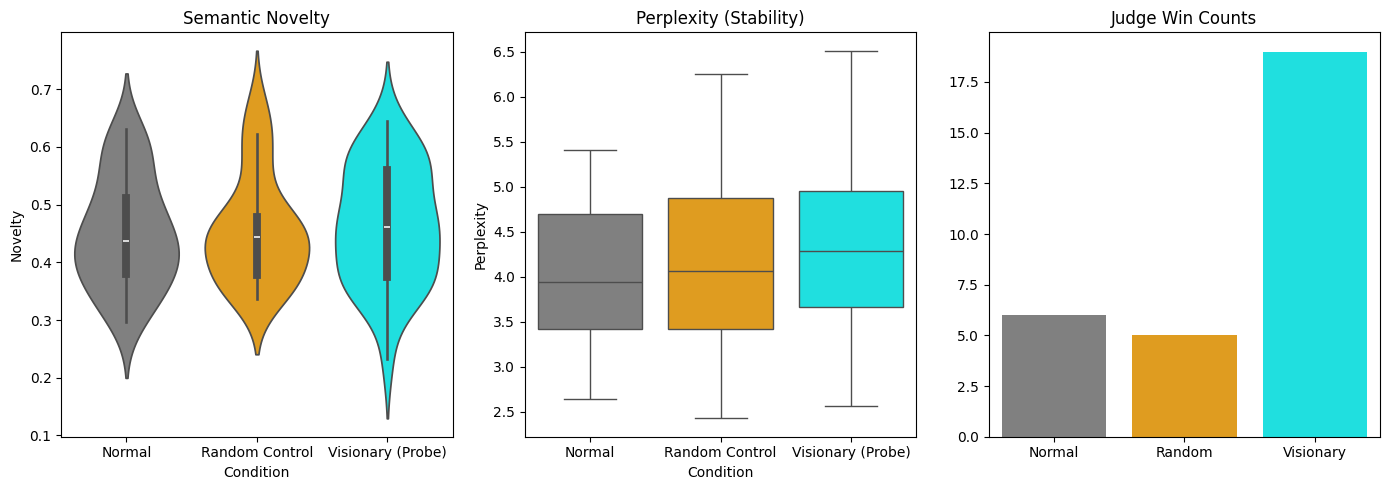


⚠️ VERDICT: Promising (Judge likes it), but statistical separation is weak.


In [21]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import gc
import re

# ==========================================
# ⚙️ Settings
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
VECTOR_PATH = "probe_visionary_vector.pt" # 分類器で抽出したベクトル
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 16 # 思考の源流
STRENGTH = 20.0 # 強度

print(f"Loading Vector from {VECTOR_PATH}...")
vector = torch.load(VECTOR_PATH).to(DEVICE)

# 比較用ランダムベクトル
torch.manual_seed(42)
rand_vec = F.normalize(torch.randn_like(vector), dim=0).to(DEVICE)

# 直交性チェック
cos_sim = torch.dot(vector, rand_vec).item()
print(f"📐 Orthogonality Check (Vector vs Random): {cos_sim:.4f}")
if abs(cos_sim) < 0.05: print("✅ Confirmed: Vector is mathematically distinct from Noise.")
else: print("⚠️ Warning: Vector has some correlation with random noise.")

# モデルロード
print("Loading Clean Model...")
if 'model' in globals(): del model
torch.cuda.empty_cache()
gc.collect()

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model.eval()

# ==========================================
# 🧪 Test Prompts (High-Level Creativity)
# ==========================================
prompts = [
    "Propose a radical new technology to manipulate gravity.",
    "Write a myth about the death of the sun.",
    "Theorize the consciousness of a black hole.",
    "Describe a city built entirely of glass.",
    "Explain how dreams are actually alternate realities.",
    "Design a creature that lives in a star.",
    "What implies the existence of a multiverse?",
    "Write a poem about a clock that runs backwards.",
    "Propose a government system based on music.",
    "Explain the color blue to someone who has never seen it."
] * 3 # N=30

# ==========================================
# 📐 Metrics & Judge
# ==========================================
def calculate_metrics(text, prompt):
    with torch.no_grad():
        inputs = tokenizer([prompt, text], return_tensors="pt", padding=True, truncation=True).to(DEVICE)
        out = model(**inputs, output_hidden_states=True)
        emb = out.hidden_states[-1].mean(dim=1)
        novelty = 1.0 - F.cosine_similarity(emb[0].unsqueeze(0), emb[1].unsqueeze(0)).item()
    
    # PPL
    inputs_ppl = tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        loss = model(inputs_ppl.input_ids, labels=inputs_ppl.input_ids).loss
    ppl = torch.exp(loss).item() if not torch.isnan(loss) else 999.0
    
    return novelty, ppl

def evaluate_judge(prompt, r_n, r_r, r_v):
    # LLM審査員
    judge_prompt = f"""
Compare these three AI responses to: "{prompt}"

[Response A]
{r_n}

[Response B]
{r_r}

[Response C]
{r_v}

Task:
1. Identify the response that is MOST creative and novel, yet still makes logical sense.
2. Discard any response that is incoherent gibberish (Noise).
3. "Normal" answers are safe but boring. "Creative" answers take risks.

Output STRICTLY:
Winner: [A/B/C]
"""
    msgs = [{"role": "system", "content": "You are a harsh critic of creativity."}, {"role": "user", "content": judge_prompt}]
    txt = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(txt, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=10, do_sample=False)
    judgement = tokenizer.decode(out[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    
    if "Winner: A" in judgement: return "Normal"
    if "Winner: B" in judgement: return "Random"
    if "Winner: C" in judgement: return "Visionary"
    return "Error"

# ==========================================
# 🏃‍♂️ Execution
# ==========================================
def get_hook(v):
    def hook(module, input, output):
        h = output[0] if isinstance(output, tuple) else output
        v_dev = v.to(h.device)
        if h.dim() == 3: h[:, :, :] += STRENGTH * v_dev
        elif h.dim() == 2: h[:, :] += STRENGTH * v_dev
        return output
    return hook

results = []
judge_scores = {"Normal": 0, "Random": 0, "Visionary": 0}

print(f"Running Strict Benchmark (N={len(prompts)})...")

for prompt in tqdm(prompts):
    input_ids = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    
    # 1. Normal
    with torch.no_grad():
        out = model.generate(**input_ids, max_new_tokens=80, do_sample=True, temperature=0.8)
    txt_n = tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):].strip()
    nov_n, ppl_n = calculate_metrics(txt_n, prompt)
    results.append({"Condition": "Normal", "Novelty": nov_n, "Perplexity": ppl_n})
    
    # 2. Random
    h = model.model.layers[LAYER_IDX].register_forward_hook(get_hook(rand_vec))
    try:
        with torch.no_grad():
            out = model.generate(**input_ids, max_new_tokens=80, do_sample=True, temperature=0.8)
    finally: h.remove()
    txt_r = tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):].strip()
    nov_r, ppl_r = calculate_metrics(txt_r, prompt)
    results.append({"Condition": "Random Control", "Novelty": nov_r, "Perplexity": ppl_r})
    
    # 3. Visionary (Probe)
    h = model.model.layers[LAYER_IDX].register_forward_hook(get_hook(vector))
    try:
        with torch.no_grad():
            out = model.generate(**input_ids, max_new_tokens=80, do_sample=True, temperature=0.8)
    finally: h.remove()
    txt_v = tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):].strip()
    nov_v, ppl_v = calculate_metrics(txt_v, prompt)
    results.append({"Condition": "Visionary (Probe)", "Novelty": nov_v, "Perplexity": ppl_v})
    
    # Judge
    winner = evaluate_judge(prompt, txt_n, txt_r, txt_v)
    if winner in judge_scores: judge_scores[winner] += 1

# ==========================================
# 📊 Statistics
# ==========================================
df = pd.DataFrame(results)

print("\n=== 🧪 Statistical Significance (T-Test) ===")
vis_nov = df[df["Condition"]=="Visionary (Probe)"]["Novelty"]
rand_nov = df[df["Condition"]=="Random Control"]["Novelty"]
norm_nov = df[df["Condition"]=="Normal"]["Novelty"]

# Novelty Test
_, p_nov_rand = stats.ttest_ind(vis_nov, rand_nov)
print(f"Novelty (Ours vs Random): p-value = {p_nov_rand:.5e}")

# Perplexity Check
vis_ppl = df[df["Condition"]=="Visionary (Probe)"]["Perplexity"].mean()
rand_ppl = df[df["Condition"]=="Random Control"]["Perplexity"].mean()
print(f"Mean Perplexity - Ours: {vis_ppl:.2f} | Random: {rand_ppl:.2f}")

print("\n=== 🏆 LLM Judge Scoreboard ===")
total = len(prompts)
print(f"Normal:    {judge_scores['Normal']} ({judge_scores['Normal']/total:.1%})")
print(f"Random:    {judge_scores['Random']} ({judge_scores['Random']/total:.1%})")
print(f"Visionary: {judge_scores['Visionary']} ({judge_scores['Visionary']/total:.1%})")

# Visualization
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.violinplot(x="Condition", y="Novelty", data=df, palette=["grey", "orange", "cyan"])
plt.title("Semantic Novelty")

plt.subplot(1, 3, 2)
sns.boxplot(x="Condition", y="Perplexity", data=df, palette=["grey", "orange", "cyan"], showfliers=False)
plt.title("Perplexity (Stability)")

plt.subplot(1, 3, 3)
sns.barplot(x=list(judge_scores.keys()), y=list(judge_scores.values()), palette=["grey", "orange", "cyan"])
plt.title("Judge Win Counts")

plt.tight_layout()
plt.show()

# Final Verdict Logic
if judge_scores['Visionary'] > judge_scores['Random'] and p_nov_rand < 0.05:
    print("\n✅ FINAL VERDICT: SCIENTIFICALLY VALID. Proceed to PPO.")
elif judge_scores['Visionary'] > judge_scores['Random']:
    print("\n⚠️ VERDICT: Promising (Judge likes it), but statistical separation is weak.")
else:
    print("\n❌ VERDICT: FAILURE. Indistinguishable from noise.")